# Train a `biolord` model over the spatiotemporally resolved single cell atlas of the Plasmodium for infected state analysis

This notebook relies on pre-processed data obatained in `1_spatio-temporal-infection_preprocessing.ipynb`<br>
Alternatively the processed adata can be downloaded from figshare, [`adata_infected.h5ad`](https://figshare.com/ndownloader/files/39375713).

Here we train a `biolord` model on the spatio-temporally resolved single cell atlas of the Plasmodium liver stage[[1]](https://www.nature.com/articles/s41586-022-05406-5) to recover gene expression trends associated with infected state.

[[1] Afriat, Amichay, Vanessa Zuzarte-Luís, Keren Bahar Halpern, Lisa Buchauer, Sofia Marques, Ângelo Ferreira Chora, Aparajita Lahree, Ido Amit, Maria M. Mota, and Shalev Itzkovitz. "A spatiotemporally resolved single-cell atlas of the Plasmodium liver stage." Nature 611, no. 7936 (2022): 563-569.](https://www.nature.com/articles/s41586-022-05406-5)



## load packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import scanpy as sc
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import ttest_rel

import biolord

[rank: 0] Global seed set to 0


In [3]:
sys.path.append("../../")
from paths import DATA_DIR, FIG_DIR

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

## Set parameters

In [4]:
import mplscience

mplscience.set_style()
plt.rcParams["legend.scatterpoints"] = 1

In [5]:
DATA_DIR_LCL = str(DATA_DIR) + "/spatio-temporal-infection/"
FIG_DIR_LCL = str(FIG_DIR) + "/spatio-temporal-infection/"

## Import pre-processed data

In [6]:
adata = sc.read(
    DATA_DIR_LCL + "adata_infected.h5ad",
    backup_url="https://figshare.com/ndownloader/files/39375713",
)

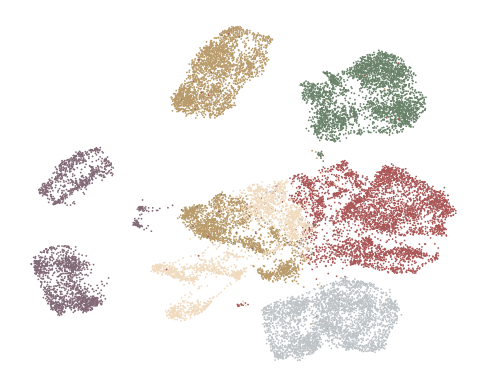

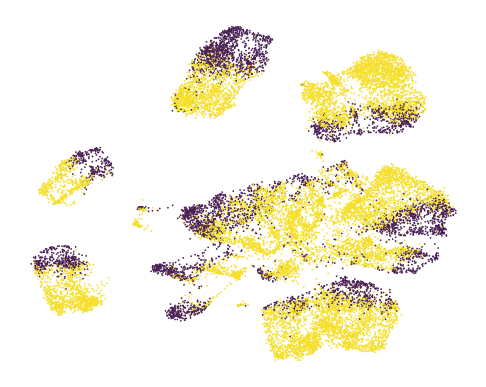

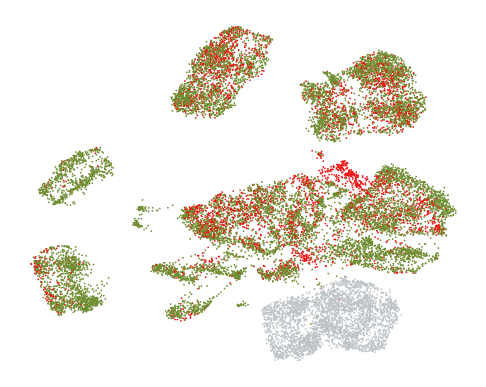

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


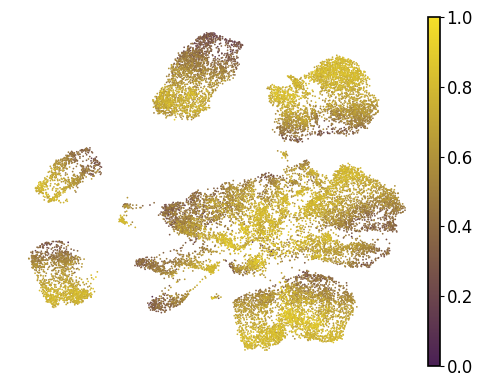

In [7]:
for c in ["coarse_time", "zone", "status_control", "eta_normalized"]:
    fig, axs = plt.subplots(1, 1, figsize=(5, 4))

    sc.pl.umap(
        adata,
        color=[c],
        ax=axs,
        show=False,
        cmap=sns.color_palette("blend:#4A2055,#F5DF28", as_cmap=True),
    )

    axs.set_title("")
    axs.set_axis_off()
    plt.legend().remove()
    plt.tight_layout()
    plt.savefig(
        FIG_DIR_LCL + f"all_cells_{c}_nleg.png",
        dpi=300,
        bbox_inches="tight",
        transparent=True,
    )
    plt.show()

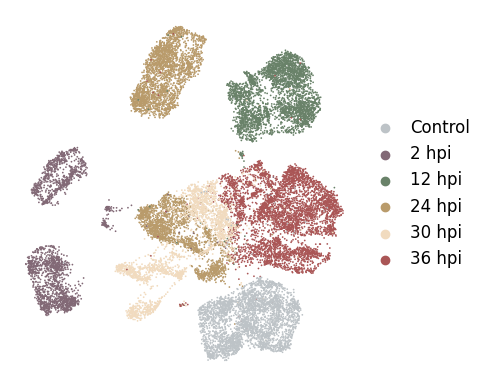

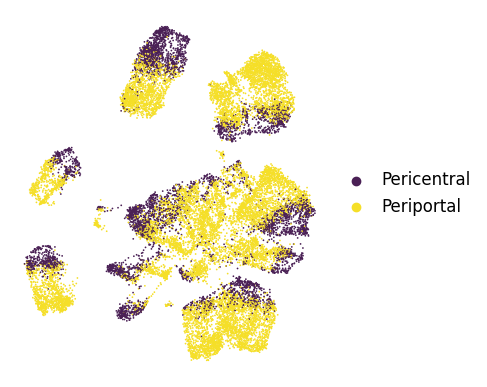

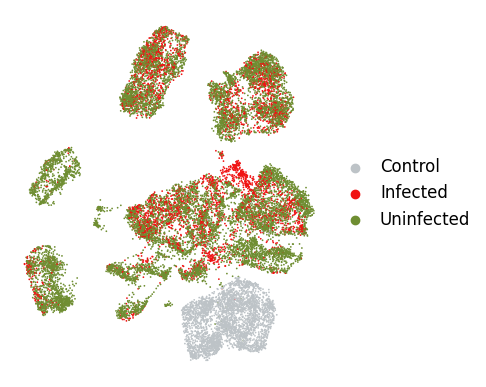

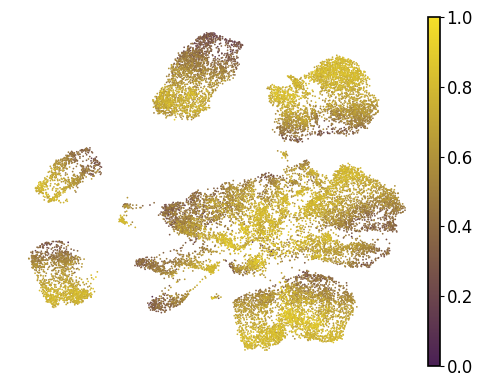

In [8]:
for c in ["coarse_time", "zone", "status_control", "eta_normalized"]:
    fig, axs = plt.subplots(1, 1, figsize=(5, 4))

    sc.pl.umap(
        adata,
        color=[c],
        ax=axs,
        show=False,
        cmap=sns.color_palette("blend:#4A2055,#F5DF28", as_cmap=True),
    )

    axs.set_title("")
    axs.set_axis_off()
    plt.tight_layout()
    plt.savefig(
        FIG_DIR_LCL + f"all_cells_{c}.png",
        dpi=300,
        bbox_inches="tight",
        transparent=True,
    )
    plt.show()

In [9]:
biolord.Biolord.setup_anndata(
    adata,
    ordered_attributes_keys=None,
    categorical_attributes_keys=["time_int", "status_control", "zone"],
    retrieval_attribute_key=None,
)

## Train model

In [10]:
module_params = {
    "autoencoder_width": 1024,
    "autoencoder_depth": 4,
    "attribute_nn_width": 512,
    "attribute_nn_depth": 2,
    "use_batch_norm": False,
    "use_layer_norm": False,
    "unknown_attribute_noise_param": 1e-1,
    "seed": 42,
    "n_latent_attribute_ordered": 4,
    "n_latent_attribute_categorical": 4,
    "gene_likelihood": "normal",
    "reconstruction_penalty": 1e2,
    "unknown_attribute_penalty": 1e1,
    "attribute_dropout_rate": 0.1,
    "eval_r2_ordered": False,
}

In [11]:
model = biolord.Biolord(
    adata=adata,
    n_latent=32,
    model_name="spatio_temporal_infected",
    module_params=module_params,
    train_classifiers=False,
    split_key="split_random",
)

[rank: 0] Global seed set to 42


In [12]:
trainer_params = {
    "n_epochs_warmup": 0,
    "autoencoder_lr": 1e-4,
    "autoencoder_wd": 1e-4,
    "attribute_nn_lr": 1e-2,
    "attribute_nn_wd": 4e-8,
    "step_size_lr": 45,
    "cosine_scheduler": True,
    "scheduler_final_lr": 1e-5,
}

In [13]:
model.train(
    max_epochs=500,
    batch_size=512,
    plan_kwargs=trainer_params,
    early_stopping=True,
    early_stopping_patience=20,
    check_val_every_n_epoch=10,
    num_workers=1,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 70/500:  14%|█▍        | 70/500 [02:46<17:00,  2.37s/it, v_num=1, val_generative_mean_accuracy=0.964, val_generative_var_accuracy=0.776, val_biolord_metric=0.87, val_reconstruction_loss=18.8, val_unknown_attribute_penalty_loss=22, generative_mean_accuracy=0, generative_var_accuracy=0, biolord_metric=0, reconstruction_loss=18, unknown_attribute_penalty_loss=30.2]     
Monitored metric val_biolord_metric did not improve in the last 20 records. Best score: 0.874. Signaling Trainer to stop.


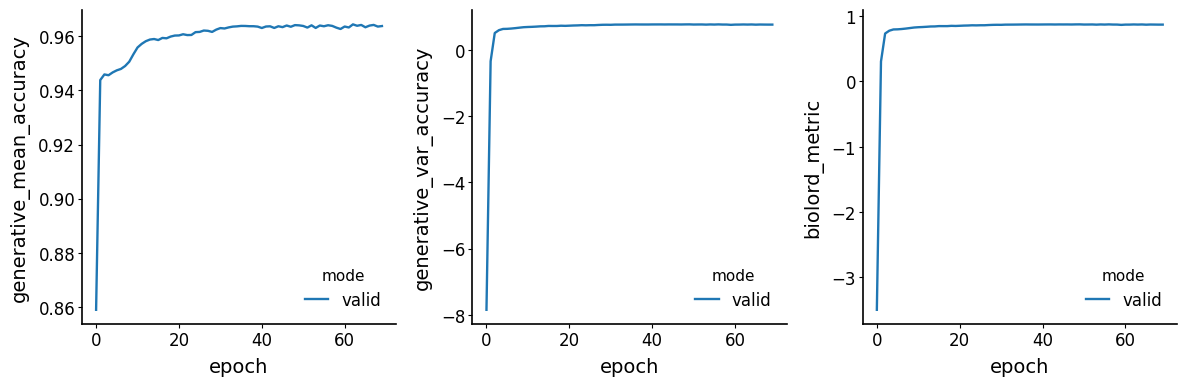

In [14]:
vals = ["generative_mean_accuracy", "generative_var_accuracy", "biolord_metric"]
fig, axs = plt.subplots(nrows=1, ncols=len(vals), figsize=(4 * len(vals), 4))

model.epoch_history = pd.DataFrame().from_dict(model.training_plan.epoch_history)
for i, val in enumerate(vals):
    sns.lineplot(
        x="epoch",
        y=val,
        hue="mode",
        data=model.epoch_history[model.epoch_history["mode"] == "valid"],
        ax=axs[i],
    )

plt.tight_layout()
plt.show()

## compute predictions

In [15]:
idx_source = np.where(
    (adata.obs["split_random"] == "train") & (adata.obs["coarse_time"] == "Control")
)[0]

adata_source = adata[idx_source].copy()

In [16]:
adata_preds = model.compute_prediction_adata(
    adata,
    adata_source,
    target_attributes=["status_control"],
    add_attributes=["zone", "eta_normalized"],
)

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


0it [00:00, ?it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


1it [00:00,  4.64it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


2it [00:00,  3.95it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


3it [00:01,  2.44it/s]


In [17]:
sc.pp.pca(adata_preds)
sc.pp.neighbors(adata_preds)
sc.tl.umap(adata_preds)

In [18]:
adata_preds.obs["status_control_counter"] = adata_preds.obs["status_control"].copy()
adata_preds.obs["status_control_counter"] = adata_preds.obs[
    "status_control_counter"
].cat.rename_categories(
    {"Infected": "Infected (c-pred.)", "Uninfected": "Uninfected (c-pred.)"}
)

adata_preds.uns["status_control_counter_colors"] = ["#bdc3c7", "#f01313", "#6f8e32"]

In [19]:
classes_plot = ["status_control_counter", "zone", "eta_normalized"]

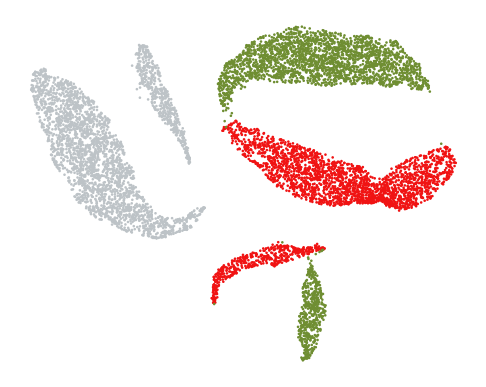

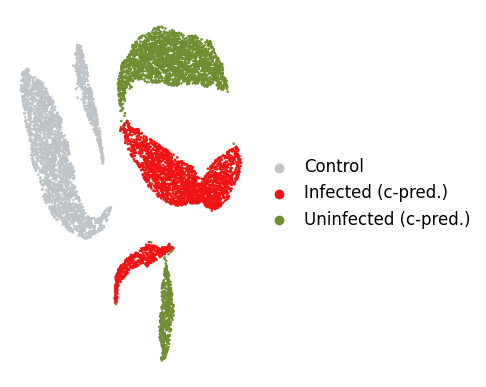

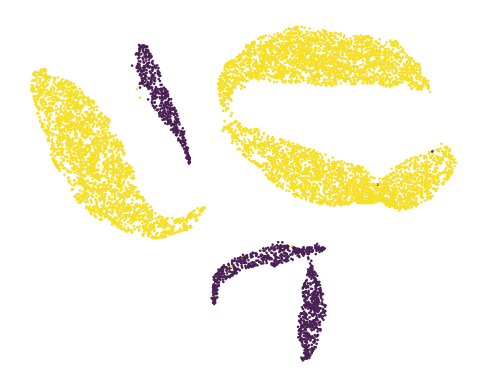

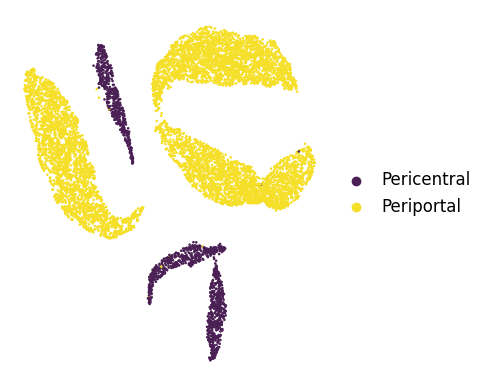

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


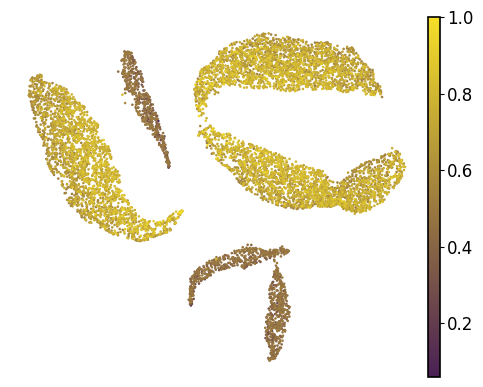

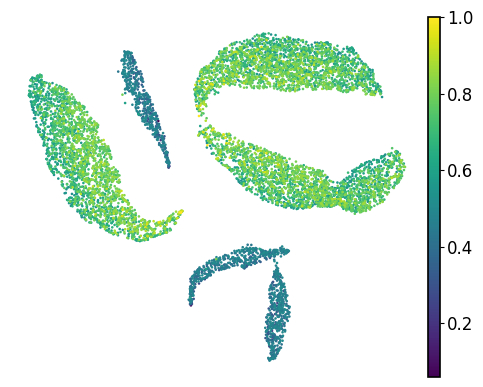

In [20]:
for c in classes_plot:
    fig, axs = plt.subplots(1, 1, figsize=(5, 4))

    sc.pl.umap(
        adata_preds,
        color=[c],
        ax=axs,
        show=False,
        cmap=sns.color_palette("blend:#4A2055,#F5DF28", as_cmap=True),
    )

    axs.set_title("")
    axs.set_axis_off()
    plt.legend().remove()
    plt.tight_layout()
    plt.savefig(
        FIG_DIR_LCL + f"control_predictions_{c}_nleg.png",
        dpi=300,
        bbox_inches="tight",
        transparent=True,
    )
    plt.show()

    fig, axs = plt.subplots(1, 1, figsize=(5, 4))

    sc.pl.umap(adata_preds, color=[c], ax=axs, show=False)

    axs.set_title("")
    axs.set_axis_off()
    plt.tight_layout()
    plt.savefig(
        FIG_DIR_LCL + f"control_predictions_{c}_leg.png",
        dpi=300,
        bbox_inches="tight",
        transparent=True,
    )
    plt.show()

### Score genes

In [21]:
scores_genes_ttest = {}
for gene in adata_source.var_names:
    res = ttest_rel(
        a=adata_preds[adata_preds.obs["status_control"] == "Infected", gene].X,
        b=adata_preds[adata_preds.obs["status_control"] == "Control", gene].X,
    )

    scores_genes_ttest[gene] = {"statistic": res.statistic[0], "pvalue": res.pvalue[0]}

In [22]:
df_pvalue = pd.DataFrame.from_dict(scores_genes_ttest).T

In [23]:
df_pvalue[df_pvalue["pvalue"] < 0.05].to_csv(DATA_DIR_LCL + "infected_ttest.csv")

### Load GSEA output

Run GSEA analysis in `R` using `2b_spatio-temporal-infected_GSEA.Rmd` and load results.

In [33]:
df_hallmark = pd.read_csv(DATA_DIR_LCL + "hallmark_infected.csv")
df_hallmark = df_hallmark.sort_values(by=["NES"], ascending=False)
df_hallmark["GO term"] = df_hallmark["Description"].copy()
GO_terms = []
for str_ in df_hallmark["GO term"]:
    str_ = str_.split("_")
    str_ = " ".join(str_[1:])
    list_ = re.findall(r"[\w]+", str_)
    if len(str_) > 30:
        idx_ = int(len(list_) / 2 - 1)
        list_[idx_] = list_[idx_] + "\n" + list_[idx_ + 1]
        list_.pop(idx_ + 1)
        str_ = " ".join(list_)
    GO_terms.append(str_.lower().capitalize() + " (H)")

df_hallmark.iloc[:, -1] = GO_terms

In [34]:
df_kegg = pd.read_csv(DATA_DIR_LCL + "kegg_infected.csv")
df_kegg = df_kegg.sort_values(by=["NES"], ascending=False)
df_kegg["GO term"] = df_kegg["Description"].copy()
GO_terms = []
for str_ in df_kegg["GO term"]:
    # str_ = str_.split("_")
    # str_ = " ".join(str_[1:])
    list_ = re.findall(r"[\w]+", str_)
    if len(str_) > 30:
        idx_ = int(len(list_) / 2 - 1)
        list_[idx_] = list_[idx_] + "\n" + list_[idx_ + 1]
        list_.pop(idx_ + 1)
        str_ = " ".join(list_)
    GO_terms.append(str_ + " (K)")

df_kegg.iloc[:, -1] = GO_terms

In [35]:
df_gsea = pd.concat((df_hallmark, df_kegg))

In [36]:
df_gsea["$-log_{10}(p_{adj})$"] = np.round(-1 * np.log10(df_gsea["p.adjust"]), 1)
df_gsea["Gene fraction"] = df_gsea["GeneRatio"]

In [37]:
nterms = 8
x_val = "NES"
df_gsea = df_gsea.sort_values(by=[x_val], ascending=False)

In [38]:
df_gsea[:nterms]["GO term"].values.tolist()

['Tnfa signaling via nfkb (H)',
 'Il6 jak stat3 signaling (H)',
 'IL-17 signaling pathway (K)',
 'TNF signaling pathway (K)',
 'Cytokine cytokine\nreceptor interaction (K)',
 'Inflammatory response (H)',
 'NF-kappa B signaling pathway (K)',
 'Interferon gamma response (H)']

In [39]:
GO_terms = [
    "TNF signaling via NF-" + r"$\kappa$" + "B (H)",
    "IL6-JAK-STAT signaling (H)",
    "Inflammatory response (H)",
    "Cytokine-cytokine     \nreceptor interaction (K)",
    "IL-17 signaling pathway (K)",
    "TNF signaling pathway (K)",
    "NF-" + r"$\kappa$" + "B signaling pathway (K)",
    "Interferon gamma response (H)",
]

In [40]:
df_gsea_lim = df_gsea[:nterms].copy()
df_gsea_lim["GO terms"] = GO_terms

In [41]:
sns.cubehelix_palette(
    n_colors=nterms,
    start=0.5,
    rot=-0.75,
    dark=0.4,
)

[[0.8423298817793848, 0.8737404427964184, 0.7524954030731037],
 [0.7426963876807406, 0.8332389163680605, 0.6710481261676083],
 [0.6283696033283754, 0.7897955559724575, 0.6098017983088719],
 [0.5233912243832719, 0.7431535312923059, 0.5758671035002841],
 [0.4249554623043753, 0.6832727386831273, 0.5594464470114257],
 [0.35127828962622354, 0.6154831763476755, 0.5535729939671293],
 [0.2958858732022419, 0.532095403269888, 0.5458447574597934],
 [0.26326760320697684, 0.44589630885054404, 0.526734835696926]]

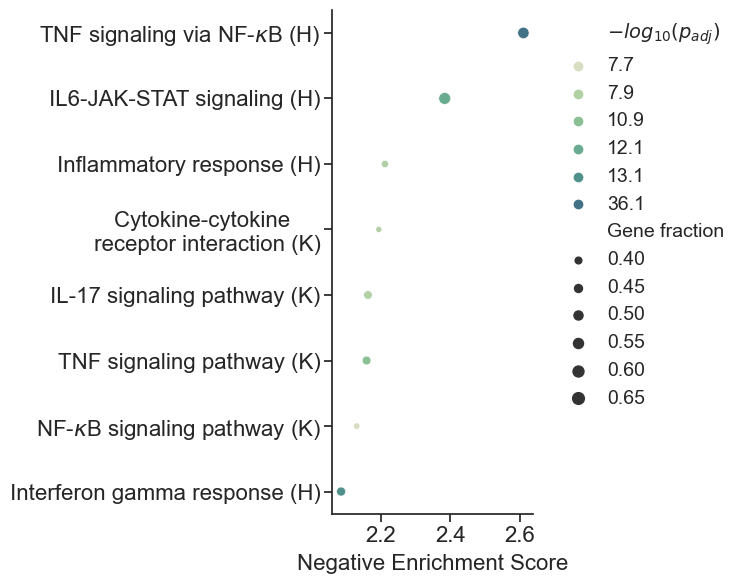

In [45]:
size = 6
fig, axs = plt.subplots(figsize=(size + 2, size))
sns.set_theme(style="white")
plt.rcParams["xtick.bottom"] = True
plt.rcParams["ytick.left"] = True

x_val = "NES"
sns.scatterplot(
    data=df_gsea_lim,
    x=x_val,
    y="GO terms",
    size="Gene fraction",
    hue="$-log_{10}(p_{adj})$",
    s=[100**n for n in range(len(df_gsea_lim["Gene fraction"]))],
    palette=sns.cubehelix_palette(
        n_colors=6,
        start=0.5,
        rot=-0.75,
        dark=0.4,
    ),
    ax=axs,
)

sns.despine(offset=0, trim=False)
plt.legend().remove()

plt.legend(
    bbox_to_anchor=(1.1, 1),
    loc="upper left",
    borderaxespad=0.2,
    frameon=False,
    ncol=1,
    fontsize=14,
)
# axs.set_xlim(0, .3)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel("")
plt.xlabel("Negative Enrichment Score", fontsize=16)

plt.tight_layout()
plt.savefig(
    FIG_DIR_LCL + "go_dots_infected_leg.png",
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)
plt.show()

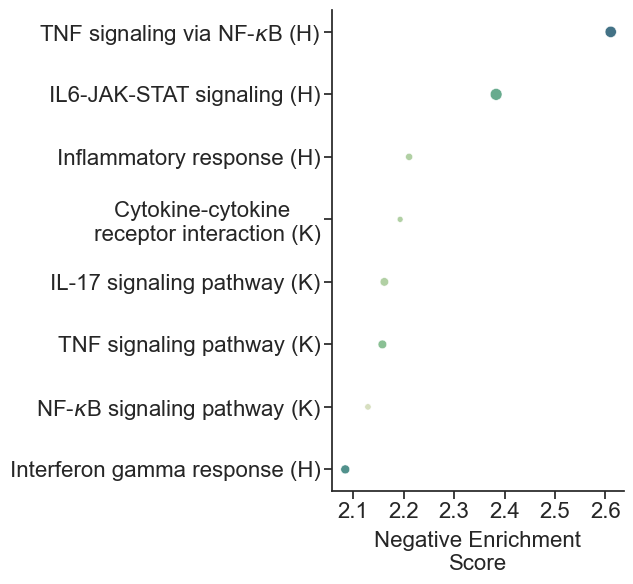

In [46]:
size = 6
fig, axs = plt.subplots(figsize=(size + 0.5, size))
sns.set_theme(style="white")
plt.rcParams["xtick.bottom"] = True
plt.rcParams["ytick.left"] = True

x_val = "NES"
sns.scatterplot(
    data=df_gsea_lim,
    x=x_val,
    y="GO terms",
    size="Gene fraction",
    hue="$-log_{10}(p_{adj})$",
    s=[100**n for n in range(len(df_gsea_lim["Gene fraction"]))],
    palette=sns.cubehelix_palette(
        n_colors=6,
        start=0.5,
        rot=-0.75,
        dark=0.4,
    ),
    ax=axs,
)

sns.despine(offset=0, trim=False)
plt.legend().remove()

plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel("")
plt.xlabel("Negative Enrichment\nScore", fontsize=16)

plt.tight_layout()
plt.savefig(
    FIG_DIR_LCL + "go_dots_infected_nleg.png",
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)
plt.show()